In [103]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import pdb
from sklearn.metrics import *
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import itertools
import csv

# Load dataset

In [2]:
genres_data = pd.read_csv(
    'movielens-dataset/u.genre', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names=['name', 'id']
)

In [3]:
movie_data_columns = np.append(
    ['movie_id', 'title', 'release_date', 'video_release_date', 'url'], 
    genres_data['name'].values
)

In [4]:
movie_data = pd.read_csv(
    'movielens-dataset/u.item', 
    sep = '|', 
    encoding = "ISO-8859-1", 
    header = None, 
    names = movie_data_columns,
    index_col = 'movie_id'
)

In [5]:
selected_columns = np.append(['title', 'release_date'], genres_data['name'].values)
movie_data = movie_data[selected_columns]
movie_data['release_date'] = pd.to_datetime(movie_data['release_date'])

movie_data.head()

,title,release_date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),1995-01-01,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),1995-01-01,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),1995-01-01,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),1995-01-01,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),1995-01-01,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
ratings_data = pd.read_csv(
    'movielens-dataset/u.data', 
    sep = '\t', 
    encoding = "ISO-8859-1", 
    header = None, 
    names=['user_id', 'movie_id', 'rating', 'timestamp']
)

In [7]:
movie_data['ratings_average'] = ratings_data.groupby(['movie_id'])['rating'].mean()
movie_data['ratings_count'] = ratings_data.groupby(['movie_id'])['rating'].count()

In [8]:
movie_data[['title', 'ratings_average', 'ratings_count']].head()

,title,ratings_average,ratings_count
movie_id,,,
1,Toy Story (1995),3.878319,452
2,GoldenEye (1995),3.206107,131
3,Four Rooms (1995),3.033333,90
4,Get Shorty (1995),3.550239,209
5,Copycat (1995),3.302326,86


# Remove null values

In [9]:
movie_data[selected_columns].isnull().any()

title           False
release_date     True
unknown         False
Action          False
Adventure       False
Animation       False
Children's      False
Comedy          False
Crime           False
Documentary     False
Drama           False
Fantasy         False
Film-Noir       False
Horror          False
Musical         False
Mystery         False
Romance         False
Sci-Fi          False
Thriller        False
War             False
Western         False
dtype: bool

In [10]:
null_release_dates = movie_data[movie_data['release_date'].isnull()]
assert null_release_dates.shape[0] == 1

In [11]:
movie_data = movie_data.drop(null_release_dates.index.values)
assert movie_data[selected_columns].isnull().any().any() == False

# Check data types

In [12]:
movie_data.dtypes

title                      object
release_date       datetime64[ns]
unknown                     int64
Action                      int64
Adventure                   int64
Animation                   int64
Children's                  int64
Comedy                      int64
Crime                       int64
Documentary                 int64
Drama                       int64
Fantasy                     int64
Film-Noir                   int64
Horror                      int64
Musical                     int64
Mystery                     int64
Romance                     int64
Sci-Fi                      int64
Thriller                    int64
War                         int64
Western                     int64
ratings_average           float64
ratings_count               int64
dtype: object

# Compute the artificial "price" and "buy_probability" attributes

In [13]:
from datetime import datetime
import dateutil

In [14]:
oldest_date = pd.to_datetime(movie_data['release_date']).min()
most_recent_date = pd.to_datetime(movie_data['release_date']).max()
normalised_age = (most_recent_date - pd.to_datetime(movie_data['release_date'])) / (most_recent_date - oldest_date)
normalised_rating = (5 - movie_data['ratings_average']) / (5 - 1)

movie_data['price'] = np.round((1 - normalised_rating) * (1 - normalised_age) * 10)
movie_data[['title', 'price', 'ratings_average', 'ratings_count']].head()

,title,price,ratings_average,ratings_count
movie_id,,,,
1,Toy Story (1995),7,3.878319,452
2,GoldenEye (1995),5,3.206107,131
3,Four Rooms (1995),5,3.033333,90
4,Get Shorty (1995),6,3.550239,209
5,Copycat (1995),5,3.302326,86


In [15]:
# one movie had title unknown, relesease data unknown, etc...
movie_data = movie_data[movie_data['price'].notnull()]

In [16]:
# the lower the price, the more likely I am going to buy
movie_data['buy_probability'] = 1 - movie_data['price'] * 0.1

# The perfect ranking

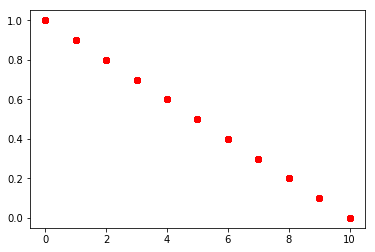

In [17]:
plt.plot(movie_data['price'].values, movie_data['buy_probability'].values, 'ro') # ro = red circles
plt.show()

## Genres distribution

In [18]:
def plot_genres(movie_data):
    genres_array = [(genre, movie_data[genre].sum()) for genre in genres_data['name'].values]
    genres_names = list(map(lambda x: x[0], genres_array))
    genres_count = list(map(lambda x: x[1], genres_array))

    genres_df = pd.DataFrame({'name': genres_names, 'count': genres_count})
    x = np.arange(len(genres_df['name'].values))
    plt.bar(x, genres_df['count'].values)
    plt.xticks(x, genres_df['name'].values, rotation='vertical')
    plt.title("Genres distribution")
    
def plot_years(movie_data):
    years = movie_data['release_date'].values.astype('datetime64[Y]').astype(int) + 1970
    plt.hist(years)
    plt.title("Years distribution")
    
def plot_ratings(movie_data):
    movie_data['ratings_average'].hist()
    plt.title("Ratings distribution")
    
def plot_price(movie_data):
    movie_data['price'].hist()
    plt.title("Price distribution")
    
def plot_ratings_count(movie_data):
    movie_data['ratings_count'].hist()
    plt.title("Ratings count")
    
def buy_probability_distribution(movie_data):
    movie_data['buy_probability'].hist(bins=11)
    plt.title("Buy probability distribution")

In [19]:
def plot_distributions(movie_data):
    fig = plt.figure(figsize=(8, 6)) 

    fig.add_subplot(3, 2, 1)
    plot_genres(movie_data)

    fig.add_subplot(3, 2, 2)
    plot_years(movie_data)

    fig.add_subplot(3, 2, 3)
    plot_ratings(movie_data)

    fig.add_subplot(3, 2, 4)
    plot_price(movie_data)

    fig.add_subplot(3, 2, 5)
    plot_ratings_count(movie_data)

    fig.add_subplot(3, 2, 6)
    buy_probability_distribution(movie_data)

    plt.tight_layout()

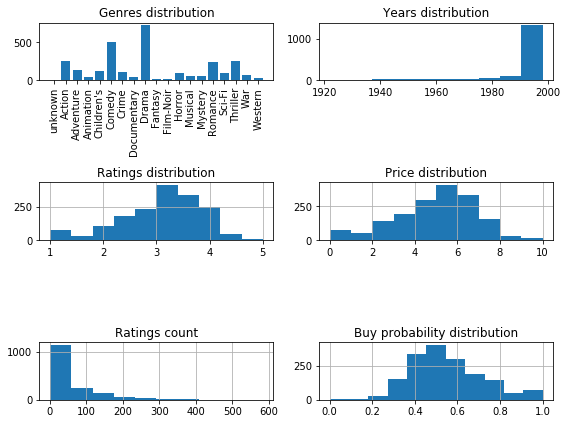

In [20]:
plot_distributions(movie_data)

# Events database functions

In [21]:
# The users database
class User:
    def __init__(self, id):
        self.id = id
        self.positive = []
        self.negative = []
        
    def add_positive(self, movie_id):
        self.positive.append(movie_id)
    
    def add_negative(self, movie_id):
        self.negative.append(movie_id)
    
    def get_positive(self):
        return self.positive
    
    def get_negative(self):
        return self.negative

In [140]:
np.random.seed(1)

class EventsGenerator:
    NUM_OF_OPENED_MOVIES_PER_USER = 20
    NUM_OF_USERS = 10

    def __init__(self, learning_data, buy_probability):
        self.learning_data = learning_data
        self.buy_probability = buy_probability
        self.users = []
        for id in range(1, self.NUM_OF_USERS):
            self.users.append(User(id))
        
    def run(self, pairwise=False):
        for user in self.users:
            opened_movies = np.random.choice(self.learning_data.index.values, self.NUM_OF_OPENED_MOVIES_PER_USER)
            self.__add_positives_and_negatives_to(user, opened_movies)

        if pairwise:
            return self.__build_pairwise_events_data()
        else:
            return self.__build_events_data()

    def __add_positives_and_negatives_to(self, user, opened_movies):
        for movie_id in opened_movies:
            if np.random.binomial(1, self.buy_probability.loc[movie_id]): 
                user.add_positive(movie_id)
            else:
                user.add_negative(movie_id)
                
    def __build_events_data(self):
        events_data = []
        
        for user in self.users:
            for positive_id in user.get_positive():
                tmp = learning_data.loc[positive_id].to_dict()
                tmp['outcome'] = 1
                events_data += [tmp]
            
            for negative_id in user.get_negative():
                tmp = learning_data.loc[negative_id].to_dict()
                tmp['outcome'] = 0
                events_data += [tmp]
                
        return pd.DataFrame(events_data)
    
    def __build_pairwise_events_data(self):
        events_data = []
        
        for i, user in enumerate(self.users):
            print("{} of {}".format(i, len(self.users)))
            positives = user.get_positive()
            negatives = user.get_negative()
            
            sample_size = min(len(positives), len(negatives))
            
            positives = np.random.choice(positives, sample_size)
            negatives = np.random.choice(negatives, sample_size)
            
            # print("Adding {} events".format(str(len(positives) * len(negatives) * 2)))
            for positive in positives:
                for negative in negatives:
                    e1 = learning_data.loc[positive].copy()
                    e1.index = [ c + '_1' for c in e1.index]

                    e2 = learning_data.loc[negative].copy()
                    e2.index = [ c + '_2' for c in e2.index]
                    
                    pos_neg_example = e1.append(e2)
                    pos_neg_example['outcome'] = 1
                    
                    neg_pos_example = e2.append(e1)
                    neg_pos_example['outcome'] = 0
                    
                    events_data.append(pos_neg_example)
                    events_data.append(neg_pos_example)
                        
        return pd.DataFrame(events_data)

In [29]:
def build_learning_data_from(movie_data):
    feature_columns = np.setdiff1d(movie_data.columns, np.array(['title', 'buy_probability']))
    learning_data = movie_data.loc[:, feature_columns]
    
    scaler = StandardScaler()
    learning_data.loc[:, ('price')] = scaler.fit_transform(learning_data[['price']])
    learning_data['ratings_average'] = scaler.fit_transform(learning_data[['ratings_average']])
    learning_data['ratings_count'] = scaler.fit_transform(learning_data[['ratings_count']])
    learning_data['release_date'] = learning_data['release_date'].apply(lambda x: x.year)
    learning_data['release_date'] = scaler.fit_transform(learning_data[['release_date']])
    
    return learning_data

In [30]:
def plot_events_distribution(events_data):
    events_data_sample = events_data.sample(frac=0.1)
    negative_outcomes = events_data_sample[events_data_sample['outcome'] == 0.0]['price']
    positive_outcomes = events_data_sample[events_data_sample['outcome'] == 1.0]['price']
    
    outcomes = np.array(list(zip(negative_outcomes.values, positive_outcomes.values)))
    plt.hist(outcomes, bins=11, label = ['Negative', 'Positive'])
    plt.legend()
    plt.xlabel('price')
    plt.show()

In [99]:
def get_feature_columns_from(learning_data, pairwise=False):
    if not pairwise:
        return learning_data.columns.values
    else:
        f1 = [c + '_1' for c in learning_data.columns.values]
        f2 = [c + '_2' for c in learning_data.columns.values]
        f1.extend(f2)
        return np.asarray(f1)

In [106]:
def save_events_data(events_data, learning_data, tag, pairwise=False):
    events_data = events_data.reindex(np.random.permutation(events_data.index))
    events_data.to_csv('movie_events_' + tag + '.csv')
    
    if not pairwise:
        df = pd.DataFrame(get_feature_columns_from(learning_data))
    else:
        #f = get_feature_columns_from(learning_data, pairwise=True)
        #np.savetxt("feature_columns.csv", f, delimiter=",", fmt="%s")
        df = pd.DataFrame(get_feature_columns_from(learning_data, pairwise=True))
    
    df.to_csv("feature_columns.csv")

In [32]:
def load_events_data(tag):
    events_data = pd.DataFrame.from_csv('movie_events_' + tag + '.csv')
    tmp = pd.DataFrame.from_csv('feature_columns.csv')
    feature_columns = tmp['0'].values
    
    return [events_data, feature_columns]

In [33]:
def get_test_train_data(events_data, feature_columns):
    X = events_data.loc[:, feature_columns].values.astype(np.float32)
    print('overall input shape: ' + str(X.shape))

    y = events_data.loc[:, ['outcome']].values.astype(np.float32).ravel()
    print('overall output shape: ' + str(y.shape))

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print('training input shape: ' + str(X_train.shape))
    print('training output shape: ' + str(y_train.shape))

    print('testing input shape: ' + str(X_test.shape))
    print('testing output shape: ' + str(y_test.shape))
    
    return [X_train, X_test, y_train, y_test]

# Generate linear events

In [34]:
learning_data = build_learning_data_from(movie_data)

In [29]:
events_data = EventsGenerator(learning_data, movie_data['buy_probability']).run()

In [ ]:
save_events_data(events_data, learning_data, 'linear')

In [76]:
events_data, feature_columns = load_events_data('linear')

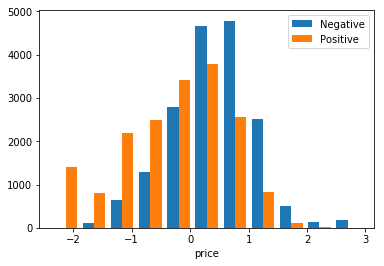

In [33]:
plot_events_distribution(events_data)

## Pairwise

In [ ]:
events_data = EventsGenerator(learning_data, movie_data['buy_probability']).run(pairwise=True)

In [142]:
save_events_data(events_data, learning_data, 'pairwise-linear', pairwise=True)

In [143]:
events_data, feature_columns = load_events_data('pairwise-linear')

In [144]:
events_data.shape

(1258, 47)

# Train/Test data split

In [137]:
X_train, X_test, y_train, y_test = get_test_train_data(events_data, feature_columns)

overall input shape: (1258, 46)
overall output shape: (1258,)
training input shape: (1006, 46)
training output shape: (1006,)
testing input shape: (252, 46)
testing output shape: (252,)


# Ranking with Amazon ML

![title](amazon_performance.png)

# Utility functions

In [120]:
def plot_rank(features, model, learning_data, predict_fun):
    lg_input = learning_data.values.astype(np.float32)
    print('overall input shape: ' + str(lg_input.shape))

    learning_data_with_rank = learning_data.copy()
    learning_data_with_rank['rank'] = predict_fun(model, lg_input)
    
    for idx, feature in enumerate(features):
        plt.subplot(len(features), 1, idx + 1)
        plt.plot(learning_data_with_rank[feature].values, learning_data_with_rank['rank'].values, 'ro')
        plt.xlabel(feature)
        plt.ylabel('rank')
        
    plt.tight_layout()
    plt.show()

In [121]:
def train_model(model, prediction_function, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    
    y_train_pred = prediction_function(model, X_train)

    print('train precision: ' + str(precision_score(y_train, y_train_pred)))
    print('train recall: ' + str(recall_score(y_train, y_train_pred)))
    print('train accuracy: ' + str(accuracy_score(y_train, y_train_pred)))

    y_test_pred = prediction_function(model, X_test)

    print('test precision: ' + str(precision_score(y_test, y_test_pred)))
    print('test recall: ' + str(recall_score(y_test, y_test_pred)))
    print('test accuracy: ' + str(accuracy_score(y_test, y_test_pred)))
    
    return model

# Rank with the perfect predictor

In [81]:
def get_predicted_outcome(model, data):
    return np.rint(model.predict(data))

In [82]:
def get_predicted_rank(model, data):
    return model.predict(data)

In [83]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [84]:
class PerfectPredictor:
    def fit(self, X, y):
        return None
    
    def predict(self, X):
        min_max_scaler = preprocessing.MinMaxScaler()
        return 1 - min_max_scaler.fit_transform(X[:, -5])

train precision: 0.725068771013
train recall: 0.586215417795
train accuracy: 0.646063553178
test precision: 0.719687456397
test recall: 0.584396456006
test accuracy: 0.645157257863
overall input shape: (1681, 23)


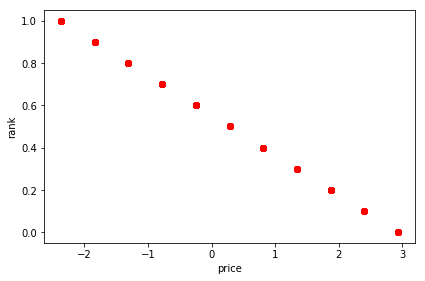

In [85]:
model = train_model(PerfectPredictor(), get_predicted_outcome, X_train, y_train, X_test, y_test)
plot_rank(['price'], model, learning_data, get_predicted_rank)

# Rank with a Logistic Regression

* Collect for each movie the buy probability from the raw events
* Run a beta regression

=> Expect the coefficients to represent the artificial probability function

In [86]:
def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)

In [87]:
def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

In [88]:
model = train_model(LogisticRegression(), get_predicted_outcome, X_train, y_train, X_test, y_test)

train precision: 0.664361338798
train recall: 0.742903838161
train accuracy: 0.648094904745
test precision: 0.658046496675
test recall: 0.742086061952
test accuracy: 0.644982249112


overall input shape: (1681, 23)


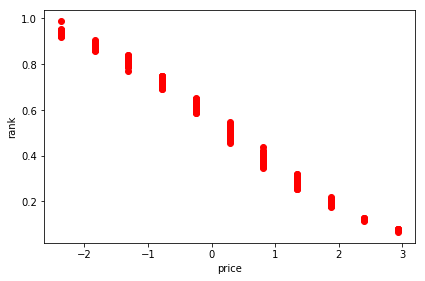

In [90]:
plot_rank(['price'], model, learning_data, get_predicted_rank)

# Rank with Neural Network

In [123]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from lasagne.nonlinearities import softmax
from nolearn.lasagne import NeuralNet

/Users/motta/.pyenv/versions/learning-to-rank/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [91]:
def nn():
    return NeuralNet(
        layers=[  # three layers: one hidden layer
            ('input', layers.InputLayer),
            ('hidden', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        # layer parameters:
        input_shape=(None, 23),  # this code won't compile without SIZE being set
        hidden_num_units=46,  # number of units in hidden layer
        output_nonlinearity=None,  # output layer uses identity function
        output_num_units=1,  # this code won't compile without OUTPUTS being set

        # optimization method:
        update_learning_rate=0.01, 
        regression=True,  # If you're doing classification you want this off
        max_epochs=50,  # more epochs can be good, 
        verbose=1, # enabled so that you see meaningful output when the program runs
    )

/Users/motta/.pyenv/versions/learning-to-rank/lib/python3.5/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [92]:
def get_predicted_outcome(model, data):
    return np.rint(model.predict(data))

In [93]:
def get_predicted_rank(model, data):
    return model.predict(data)

In [ ]:
model = train_model(
    nn(), 
    get_predicted_outcome, 
    X_train.astype(np.float32), 
    y_train.astype(np.float32), 
    X_test.astype(np.float32), 
    y_test.astype(np.float32)
)

overall input shape: (1681, 23)


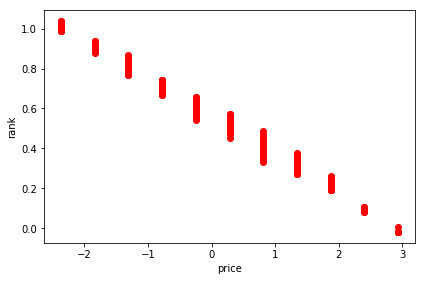

In [95]:
plot_rank(['price'], model, learning_data, get_predicted_rank)

# Rank with Decision Trees

In [96]:
def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)

In [97]:
def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

In [98]:
from sklearn import tree
model = train_model(tree.DecisionTreeClassifier(), get_predicted_outcome, X_train, y_train, X_test, y_test)

train precision: 0.680947848951
train recall: 0.711256135779
train accuracy: 0.653892069603
test precision: 0.668242778542
test recall: 0.704538759602
test accuracy: 0.644044702235


overall input shape: (1681, 23)


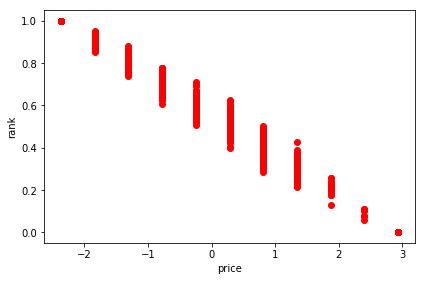

In [99]:
plot_rank(['price'], model, learning_data, get_predicted_rank)

# Customers with non-linear buying behaviour

In [100]:
price_component = np.sqrt(movie_data['price'] * 0.1)
ratings_component = np.sqrt(movie_data['ratings_average'] * 0.1 * 2)
movie_data['buy_probability'] = 1 - price_component * 0.2 - ratings_component * 0.8

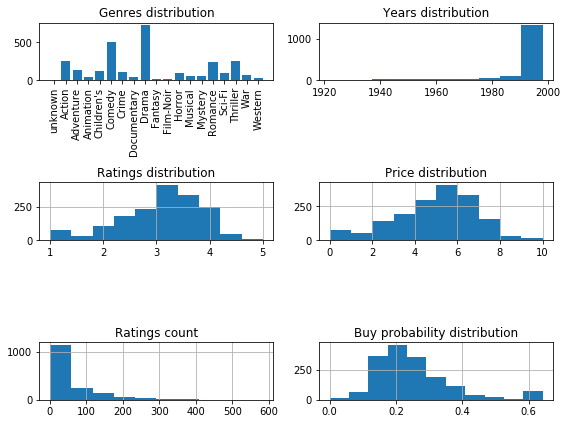

In [101]:
plot_distributions(movie_data)

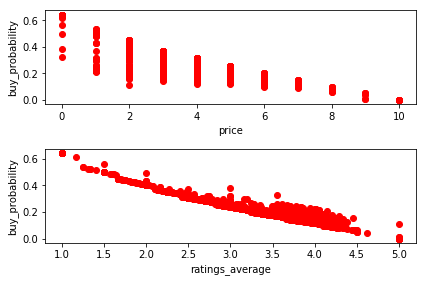

In [102]:
plt.subplot(2, 1, 1)
plt.plot(movie_data['price'].values, movie_data['buy_probability'].values, 'ro') # ro = red circles
plt.xlabel('price')
plt.ylabel('buy_probability')

plt.subplot(2, 1, 2)
plt.plot(movie_data['ratings_average'].values, movie_data['buy_probability'].values, 'ro') # ro = red circles
plt.xlabel('ratings_average')
plt.ylabel('buy_probability')

plt.tight_layout()
plt.show()

# Create events

In [103]:
learning_data = build_learning_data_from(movie_data)

In [69]:
positive_events, negative_events = generate_events()
events_data = build_events_data(positive_events, negative_events, learning_data)
save_events_data(events_data, learning_data, 'nonlinear')

In [104]:
events_data, feature_columns = load_events_data('nonlinear')

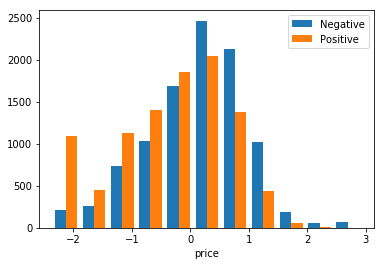

In [105]:
plot_events_distribution(events_data)

In [106]:
X_train, X_test, y_train, y_test = get_test_train_data(events_data)

overall input shape: (399980, 23)
overall output shape: (399980,)
training input shape: (319984, 23)
training output shape: (319984,)
testing input shape: (79996, 23)
testing output shape: (79996,)


# Rank with the perfect predictor

In [124]:
def get_predicted_outcome(model, data):
    return np.rint(model.predict(data))

In [125]:
def get_predicted_rank(model, data):
    return model.predict(data)

In [126]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [127]:
class PerfectPredictor:
    def fit(self, X, y):
        return None
    
    def predict(self, X):
        min_max_scaler = preprocessing.MinMaxScaler()
        price_component = np.sqrt(min_max_scaler.fit_transform(X[:, -5]))
        ratings_component = np.sqrt(min_max_scaler.fit_transform(X[:, -4]))
        return 1 - price_component * 0.2 - ratings_component * 0.8

train precision: 0.515083321464
train recall: 0.226469446288
train accuracy: 0.753787689384
test precision: 0.513203730756
test recall: 0.228281515545
test accuracy: 0.752850142507
overall input shape: (1681, 23)


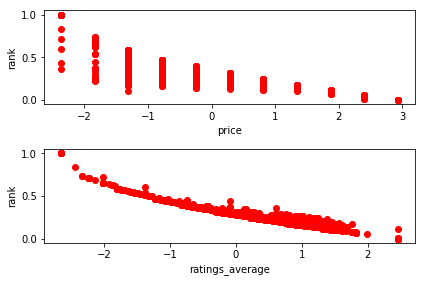

In [128]:
model = train_model(PerfectPredictor(), get_predicted_outcome, X_train, y_train, X_test, y_test)
plot_rank(['price', 'ratings_average'], model, learning_data, get_predicted_rank)

# Rank with Logistic Regression

In [107]:
def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)

In [108]:
def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

In [109]:
model = train_model(LogisticRegression(), get_predicted_outcome, X_train, y_train, X_test, y_test)

train precision: 0.613005193046
train recall: 0.136016933231
train accuracy: 0.762991274564
test precision: 0.605217010083
test recall: 0.138008597421
test accuracy: 0.761913095655


overall input shape: (1681, 23)


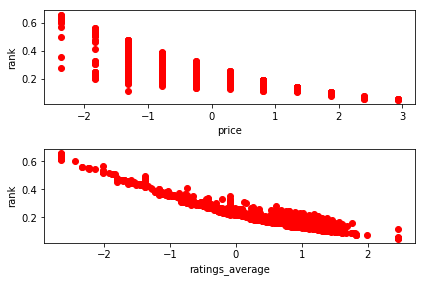

In [110]:
plot_rank(['price', 'ratings_average'], model, learning_data, get_predicted_rank)

# Rank with Neural Networks

In [111]:
def get_predicted_outcome(model, data):
    return np.rint(model.predict(data))

In [112]:
def get_predicted_rank(model, data):
    return model.predict(data)

In [ ]:
model = train_model(
    nn(), 
    get_predicted_outcome, 
    X_train.astype(np.float32), 
    y_train.astype(np.float32), 
    X_test.astype(np.float32), 
    y_test.astype(np.float32)
)

overall input shape: (1681, 23)


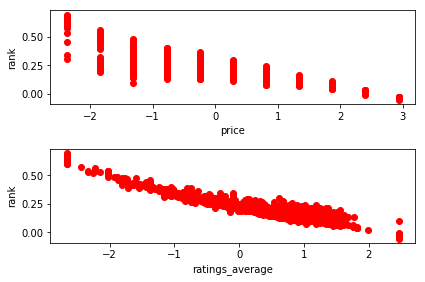

In [114]:
plot_rank(['price', 'ratings_average'], model, learning_data, get_predicted_rank)

# Rank with Decision Trees

In [115]:
def get_predicted_outcome(model, data):
    return np.argmax(model.predict_proba(data), axis=1).astype(np.float32)

In [116]:
def get_predicted_rank(model, data):
    return model.predict_proba(data)[:, 1]

In [117]:
from sklearn import tree
model = train_model(tree.DecisionTreeClassifier(), get_predicted_outcome, X_train, y_train, X_test, y_test)

train precision: 0.634287197456
train recall: 0.122427764488
train accuracy: 0.763413170659
test precision: 0.625315179022
test recall: 0.123962811157
test accuracy: 0.762338116906


overall input shape: (1681, 23)


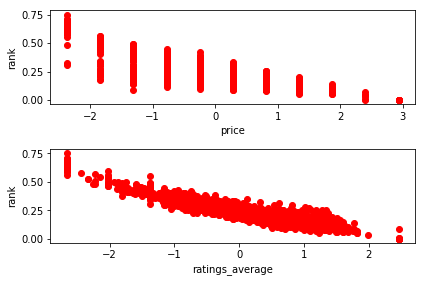

In [118]:
plot_rank(['price', 'ratings_average'], model, learning_data, get_predicted_rank)

# Pairwise learning

In [116]:
def nn():
    return NeuralNet(
        layers=[  # three layers: one hidden layer
            ('input', layers.InputLayer),
            ('hidden', layers.DenseLayer),
            ('output', layers.DenseLayer),
            ],
        # layer parameters:
        input_shape=(None, 46),  # this code won't compile without SIZE being set
        hidden_num_units=92,  # number of units in hidden layer
        output_nonlinearity=None,  # output layer uses identity function
        output_num_units=1,  # this code won't compile without OUTPUTS being set

        # optimization method:
        update_learning_rate=0.01, 
        regression=True,  # If you're doing classification you want this off
        max_epochs=50,  # more epochs can be good, 
        verbose=1, # enabled so that you see meaningful output when the program runs
    )

In [117]:
def get_predicted_outcome(model, data):
    return np.rint(model.predict(data))

In [118]:
def get_predicted_rank(model, data):
    return model.predict(data)

In [124]:
model = train_model(
    nn(), 
    get_predicted_outcome, 
    X_train.astype(np.float32), 
    y_train.astype(np.float32), 
    X_test.astype(np.float32), 
    y_test.astype(np.float32)
)

# Neural Network with 4417 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input       46
  1  hidden      92
  2  output       1

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     1.45537     0.28081    5.18282  0.01s
      2     0.43017     0.53487    0.80425  0.00s
      3     0.45262     0.60774    0.74476  0.00s
      4     0.50527     0.45868    1.10157  0.00s
      5     0.40392     0.31302    1.29040  0.00s
      6     0.31888     0.24285    1.31306  0.00s
      7     0.29740     0.22252    1.33652  0.00s
      8     0.29929     0.22347    1.33929  0.00s
      9     0.29481     0.23657    1.24621  0.00s
     10     0.28274     0.25939    1.09003  0.00s
     11     0.27059     0.28643    0.94470  0.00s
     12     0.26181     0.31058    0.84299  0.00s
     13     0.25559     0.32826    0.77864  0.00s
     14     0.25063     0.33946    0.73833  0.00s
     15     0.24653     0.3463